# N2V Prediction
Please run the ```1_N2VTraining.ipynb``` before.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tifffile import imread
import sys
sys.path.append('../../../')
from unet.model import UNet
from pn2v.utils import denormalize
from pn2v.utils import normalize
from pn2v.utils import PSNR
from pn2v import utils
from pn2v import prediction
import pn2v.training
from pn2v import histNoiseModel

# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

In [2]:
# We need the training data in order to calulate 'mean' and 'std' for normalization
path='../../../data/Mouse skull nuclei/'

# Load the test data
dataTest=imread(path+"example2_digital_offset300.tif")[:,:,:256] 
# We are loading only a sub image to speed up computation

# We estimate the ground truth by averaging.
dataTestGT=np.mean(dataTest[:,...],axis=0)[np.newaxis,...]


### Load the Network and Noise Model
Ensure that ```dataName``` is set same as in ```01_N2VTraining.ipynb```.

In [3]:
dataName = 'mouseskullnuclei' # Use the same name as used in N2VTraining.ipynb. This is a part of model name created in N2VTraining.ipynb 
nameModel=dataName+'_n2v'

### Load the Network

In [4]:
# Load the network, created in the '01_N2VTraining.ipynb' notebook
net=torch.load(path+"/last_"+nameModel+".net")

/home/lalit/Desktop/01_Softwares/anaconda3/envs/ppn2vEnv/lib/python3.7/site-packages/torch/cuda/__init__.py:118: UserWarning: 
    Found GPU1 NVS 310 which is of cuda capability 2.1.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


### Evaluation

image: 0
PSNR input 28.02423798473431
PSNR prior 35.600548044910234
PSNR mse 35.600548044910234
-----------------------------------
image: 1
PSNR input 28.065531602490644
PSNR prior 35.700809762206326
PSNR mse 35.700809762206326
-----------------------------------
image: 2
PSNR input 28.035021421910734
PSNR prior 35.71221516036974
PSNR mse 35.71221516036974
-----------------------------------
image: 3
PSNR input 28.087744381628678
PSNR prior 35.74915249231629
PSNR mse 35.74915249231629
-----------------------------------
image: 4
PSNR input 28.061745249613562
PSNR prior 35.63948126224223
PSNR mse 35.63948126224223
-----------------------------------
image: 5
PSNR input 28.1086316653067
PSNR prior 35.732168824125715
PSNR mse 35.732168824125715
-----------------------------------
image: 6
PSNR input 28.11584919615069
PSNR prior 35.80812967991228
PSNR mse 35.80812967991228
-----------------------------------
image: 7
PSNR input 28.078571033189487
PSNR prior 35.74191055859506
PSNR mse 35.7

image: 66
PSNR input 28.129393849352013
PSNR prior 35.7924496159444
PSNR mse 35.7924496159444
-----------------------------------
image: 67
PSNR input 28.11863774042713
PSNR prior 35.758509521873194
PSNR mse 35.758509521873194
-----------------------------------
image: 68
PSNR input 28.0744924081312
PSNR prior 35.76290488478017
PSNR mse 35.76290488478017
-----------------------------------
image: 69
PSNR input 28.087115550087496
PSNR prior 35.82142401560962
PSNR mse 35.82142401560962
-----------------------------------
image: 70
PSNR input 28.100664171847036
PSNR prior 35.824785669260265
PSNR mse 35.824785669260265
-----------------------------------
image: 71
PSNR input 28.1022497917701
PSNR prior 35.78349164637578
PSNR mse 35.78349164637578
-----------------------------------
image: 72
PSNR input 28.147053880531487
PSNR prior 35.75964263769687
PSNR mse 35.75964263769687
-----------------------------------
image: 73
PSNR input 28.10360697863469
PSNR prior 35.8264780155718
PSNR mse 35.

image: 132
PSNR input 28.115379662314908
PSNR prior 35.79032044639106
PSNR mse 35.79032044639106
-----------------------------------
image: 133
PSNR input 28.136598736570747
PSNR prior 35.7897653384856
PSNR mse 35.7897653384856
-----------------------------------
image: 134
PSNR input 28.155716038813438
PSNR prior 35.83904159935295
PSNR mse 35.83904159935295
-----------------------------------
image: 135
PSNR input 28.085705019467397
PSNR prior 35.76190330676035
PSNR mse 35.76190330676035
-----------------------------------
image: 136
PSNR input 28.109437508908528
PSNR prior 35.811057475775925
PSNR mse 35.811057475775925
-----------------------------------
image: 137
PSNR input 28.120960359275994
PSNR prior 35.79701144781765
PSNR mse 35.79701144781765
-----------------------------------
image: 138
PSNR input 28.12270100924804
PSNR prior 35.786143495176596
PSNR mse 35.786143495176596
-----------------------------------
image: 139
PSNR input 28.147226761888323
PSNR prior 35.806174590518


image: 198
PSNR input 28.142133401788897
PSNR prior 35.8641214892788
PSNR mse 35.8641214892788
-----------------------------------
image: 199
PSNR input 28.110352018291994
PSNR prior 35.696554321622685
PSNR mse 35.696554321622685
-----------------------------------
Avg PSNR Prior: 35.78969937170641 +-(2SEM) 0.007837744531222584
Avg PSNR MMSE: 35.78969937170641 +-(2SEM) 0.007837744531222584


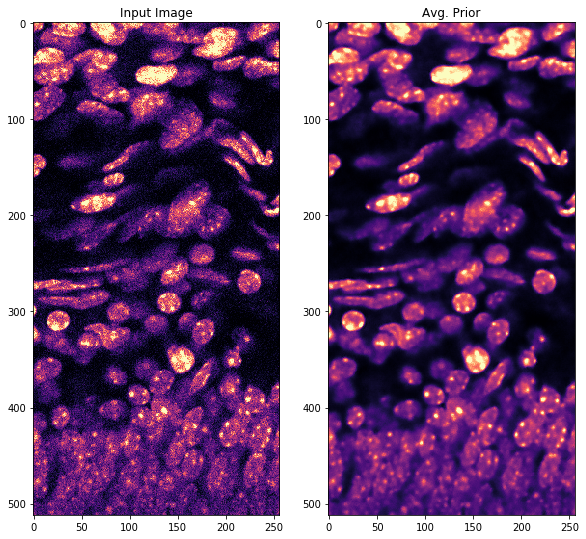

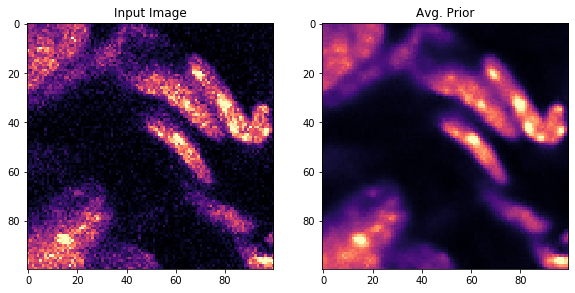

In [5]:
# Now we are processing data and calculating PSNR values.
results=[]
meanRes=[]
resultImgs=[]
inputImgs=[]

# We iterate over all test images.
for index in range(dataTest.shape[0]):
    
    im=dataTest[index]
    gt=dataTestGT[0] # The ground truth is the same for all images
    
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    
    means = prediction.tiledPredict(im, net ,ps=256, overlap=48,
                                            device=device, noiseModel=None)
    
    resultImgs.append(means)
    inputImgs.append(im)

    rangePSNR=np.max(gt)-np.min(gt)
    psnr=PSNR(gt, means,rangePSNR )
    psnrPrior=PSNR(gt, means,rangePSNR )
    results.append(psnr)
    meanRes.append(psnrPrior)

    print ("image:",index)
    print ("PSNR input",PSNR(gt, im, rangePSNR))
    print ("PSNR prior",psnrPrior) # Without info from masked pixel
    print ("PSNR mse",psnr) # MMSE estimate using the masked pixel
    print ('-----------------------------------')

    
    
    
# We display the results for the last test image       
vmi=np.percentile(gt,0.01)
vma=np.percentile(gt,99)

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title(label='Input Image')
plt.imshow(im, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 2)
plt.title(label='Avg. Prior')
plt.imshow(means, vmax=vma, vmin=vmi, cmap='magma')

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title(label='Input Image')
plt.imshow(im[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 2)
plt.title(label='Avg. Prior')
plt.imshow(means[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

print("Avg PSNR Prior:", np.mean(np.array(meanRes) ), '+-(2SEM)',2*np.std(np.array(meanRes) )/np.sqrt(float(len(meanRes)) ) )
print("Avg PSNR MMSE:", np.mean(np.array(results) ),  '+-(2SEM)' ,2*np.std(np.array(results) )/np.sqrt(float(len(results)) ) )